In [1]:
import os
import time
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,BatchNormalization,Lambda,Activation,Input,Flatten,Reshape,Conv2DTranspose,concatenate,Reshape,LeakyReLU

In [29]:
#constants
IMG_DIM = 28
# manual options
sensitive = 'color' # 'color' or 'class'
prior_dist = 0 # 0: simple gaussian 1: guassian mixture Note: if prior generator model enabled, this option is not used
mnist_type = 'balanced' # 'balanced' 'unbalanced
saved_path = "./mnist_colored"

# automatically set variables based on selected options
utility = 'class' if sensitive=='color' else 'color'
prior_type = 'Isotropic' if prior_dist == 0 else 'Mixture'
data_type = 'biased' if mnist_type=='unbalanced' else 'uniform'



data = np.load(f"{saved_path}/colored_mnist_{mnist_type}.npz")

x_train = data['x_train']
x_train = x_train.astype(np.float32) / 255.0
s_train = data['s_train'] if(sensitive == 'color') else data['y_train']
u_train = data['s_train'] if(sensitive == 'class') else data['y_train']

x_test = data['x_test']
x_test = x_test.astype(np.float32) / 255.0
s_test = data['s_test'] if(sensitive == 'color') else data['y_test']
u_test = data['s_test'] if(sensitive == 'class') else data['y_test']

In [30]:
def one_hot(labels, num_labels):
    num_labels_data = labels.shape[0]
    one_hot_encoding = np.zeros((num_labels_data,num_labels))
    one_hot_encoding[np.arange(num_labels_data),labels] = 1
    one_hot_encoding = np.reshape(one_hot_encoding, [-1, num_labels])
    return one_hot_encoding

DIM_S = 3 if(sensitive == 'color') else 10
DIM_U = 10 if(sensitive == 'color') else 3

u_train = one_hot(u_train, DIM_U).astype(np.float32)
s_train = one_hot(s_train, DIM_S).astype(np.float32)
u_test = one_hot(u_test, DIM_U).astype(np.float32)
s_test = one_hot(s_test, DIM_S).astype(np.float32)

In [4]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def get_encoder(DIM_Z, input_x):
    stride = 2
#     input_x = Input( shape = [IMG_DIM,IMG_DIM,3], name="x" )

    #first hidden layer
    x = Conv2D(64, 5, strides=stride, padding="same", name="enc_h1")(input_x)
    x = BatchNormalization(name="enc_h1_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h1_activation")(x)
    #second hidden layer
    x = Conv2D(128, 5, strides=stride, padding="same", name="enc_h2")(x)
    x = BatchNormalization(name="enc_h2_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h2_activation")(x)

    shape = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(DIM_Z*4, name="enc_dense_1")(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    z_mean = Dense(DIM_Z, name="z_mean")(x)
    z_log_sigma_sq = Dense(DIM_Z, name="z_sigma")(x)
    z = Lambda(sampling, output_shape=DIM_Z, name='z')([z_mean, z_log_sigma_sq])
    
#     prior_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    
    encoder = Model(input_x, z, name = "Encoder")
#     encoder.add_loss((alpha+beta) * prior_loss)
    
    return (encoder, z_mean, z_log_sigma_sq)

In [6]:
def get_uncertainty_model(DIM_Z):
    model = Sequential(name="Uncertainty_Decoder")
    model.add(Dense(DIM_Z * 4, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Dense(DIM_Z * 4))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(DIM_S, activation='softmax', name="s_hat"))
    return model

In [7]:
def get_utility_model(DIM_Z):
    model = Sequential(name="Utility_Decoder")
    model.add(Dense(DIM_Z * 4, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

#         model.add(Dense(DIM_Z * 4))
#         model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(DIM_U, activation='softmax', name="u_hat"))
    return model

In [8]:
def get_z_discriminator(DIM_Z):
    model = Sequential(name="Latent_Space_Discriminator")
    
    model.add(Dense(512, input_dim=DIM_Z))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [9]:
def get_utility_discriminator():
    stride = 2
    model = Sequential(name="Attribute_Class_Discriminator")

    model.add(Dense(DIM_U * 8, input_dim=DIM_U))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(DIM_U * 8))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

# Define VARIATIONAL NESTED LEAKAGE Model

In [10]:
## utility and reconstruction losses

def loss_u(u_true, u_pred):
    return K.mean(K.sum(K.square(u_true-u_pred), axis=-1))

bce = tf.keras.losses.BinaryCrossentropy()
# Weighted cross-entropy loss
def loss_wce(coef):
    def loss(y, y_pred):
         return coef * bce(y, y_pred)
    return loss

############################################################################
def get_full_model(DIM_Z, beta, learning_rate=0.0001):
    ########## Inputs
    input_x = Input( shape=[IMG_DIM,IMG_DIM,3], name="x" )
    input_z = Input( shape = (DIM_Z,), name="z" )

    ########## Define AE: Encoder, Utility Decoder
    encoder,z_mean,z_log_sigma_sq = get_encoder(DIM_Z, input_x)
    utility_decoder = get_utility_model(DIM_Z)

    z = encoder(input_x)
    u_hat = utility_decoder(z)

    autoencoder = Model(input_x, u_hat, name="Autoencoder")
    prior_loss = beta * K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    prior_loss = tf.identity(prior_loss, name="kl_loss")
    autoencoder.add_loss(prior_loss)
    autoencoder.compile(loss=loss_u, optimizer=tf.keras.optimizers.Adam(lr=learning_rate*5))

    ########## Define Latent Space Discriminator
    z_discriminator = get_z_discriminator(DIM_Z)
    z_discriminator.compile(loss=loss_wce(0.1*beta), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    z_discriminator.trainable = False
    encoder_zdiscriminator = Model(input_x, z_discriminator(encoder(input_x)), name="encoder_zdiscriminator")
    encoder_zdiscriminator.compile(loss=loss_wce(-0.1*beta), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ########## Define Utility Discriminator
    u_dircriminator = get_utility_discriminator()
    u_dircriminator.compile(loss=loss_wce(0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #u_dircriminator should train separately
    u_dircriminator.trainable = False
    decoder_udiscriminator = Model(input_z, u_dircriminator(utility_decoder(input_z)), name="decoder_udiscriminator")
    decoder_udiscriminator.compile(loss=loss_wce(-0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
    
    return encoder, utility_decoder, autoencoder, z_discriminator, encoder_zdiscriminator, u_dircriminator, decoder_udiscriminator


############################################################################
# Attacker model: Encoder (Freezed) to S-Decoder
############################################################################
def get_attacker_ae(DIM_Z, encoder, learning_rate=0.001):
    input_x = Input( shape=[IMG_DIM,IMG_DIM,3], name="x" )
    encoder.trainable = False
    uncertainty_decoder = get_uncertainty_model(DIM_Z)
    ae_attacker = Model(input_x, uncertainty_decoder(encoder(input_x)), name="Autoencoder_Attacker")
    ae_attacker.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
    return ae_attacker

# Pre-training implementation

In [11]:
def pre_train_ae(dim_z, beta, force_train=False, max_itr=50, batch_size=1024, verbose=2):
    info_str = f"d_{dim_z}_beta_{beta}_u_{utility}_s_{sensitive}_{data_type}_{prior_type}"
    if not os.path.exists(f"saved_models/mnist_pretrain_{info_str}.h5") or force_train:
        print(f"Pre-Training with {info_str}")
        autoencoder.fit(x_train, u_train, batch_size=batch_size, epochs=max_itr, shuffle=True, verbose=verbose)
        autoencoder.save_weights(f"saved_models/mnist_pretrain_{info_str}.h5")
    else:
        print(f"Loading model from file with {info_str}")
        autoencoder.load_weights(f"saved_models/mnist_pretrain_{info_str}.h5")

In [12]:
# print(sum([np.sum(w) for w in encoder.get_weights()]))

# Full model training loop 

In [13]:
from utils.sampler import gaussian, gaussian_mixture

def sample_prior(latent_dim, batch_size):
    if prior_dist == 0:  
        return gaussian(batch_size, latent_dim)
    elif prior_dist == 1:
        return gaussian_mixture(batch_size, latent_dim, num_labels=min(10, DIM_U))
    

In [14]:
def main_train(dim_z, max_itr=1000, batch_size=1024, z_disc_enabled=False,u_disc_enabled=False,verbose=0):
    ones = np.ones((batch_size, 1))
    zeros = np.zeros((batch_size, 1))
    start_time = time.time()
    for epoch in range(max_itr):
        start_time_epoch = time.time()
        # ---------------------
        #  1- Train the Encoder and the Utility Decoder
        # ---------------------
        # Select a random batch of images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x = x_train[idx]
        u = u_train[idx]
        ae_loss = autoencoder.train_on_batch(x, u)
 
        if z_disc_enabled:
        # ---------------------
        #  2- Train the Latent Space Discriminator
        # ---------------------
            latent_prior = sample_prior(dim_z, batch_size)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            latent_enc = encoder(x)

            d_loss_prior = z_discriminator.train_on_batch(latent_prior, zeros)
            d_loss_enc = z_discriminator.train_on_batch(latent_enc, ones)
            dz_loss = d_loss_prior + d_loss_enc

        # ---------------------
        # 3- Train the Encoder Adversarially
        # ---------------------

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            edz_loss = encoder_zdiscriminator.train_on_batch(x, ones)
            
        else:
            dz_loss = 0
            edz_loss = 0

        if u_disc_enabled:
        # ---------------------
        #  4- Train the Attribute_Class Discriminator 
        # ---------------------
            
            latent = sample_prior(dim_z, batch_size)
            u_dec = utility_decoder(latent)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            u = u_train[idx]

            d_loss_real = u_dircriminator.train_on_batch(u, ones)
            d_loss_fake = u_dircriminator.train_on_batch(u_dec, zeros)
            du_loss = d_loss_real + d_loss_fake

        # ---------------------
        #  5- Train the Utility Decoder Adversarially
        # ---------------------  
            latent = sample_prior(dim_z, batch_size)
            udu_loss = decoder_udiscriminator.train_on_batch(latent, zeros)
        else:
            udu_loss = 0
            du_loss = 0

        # ---------------------
        #  Print stats info
        # ---------------------
        if verbose != 0 and epoch % 100 == 0:
            print(f"{epoch}, ae:{ae_loss:.4f}, dz:{dz_loss:.5f}, edz:{edz_loss:.5f}, du:{du_loss:.4f}, udu:{udu_loss:.4f}")
            print(f"One epoch execution time: {(time.time() - start_time_epoch):.5} seconds")

    total_time = (time.time() - start_time) / 60
    print(f"Total execution time for full model loop: {total_time} minutes")

# Experiment 1

In [15]:
from utils.mine import MINE
beta_list = [10.0**i for i in range(-9,-3)]
beta_list.extend([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0])
DIM_Z = [8, 64]
s_data_ratio = [0.01, 1.0]

util_acc_tr = np.zeros((len(DIM_Z),len(beta_list)))
util_acc_ts = np.zeros((len(DIM_Z),len(beta_list)))
sens_acc_ts = np.zeros((len(DIM_Z),len(beta_list),len(s_data_ratio)))
mi_s = np.zeros((len(DIM_Z),len(beta_list)))
mi_u_ts = np.zeros((len(DIM_Z),len(beta_list)))
mi_u_tr = np.zeros((len(DIM_Z),len(beta_list)))


s_all = np.vstack((s_train, s_test))


for i, dimz in enumerate(DIM_Z):
    for j, beta in enumerate(beta_list):
        encoder, utility_decoder, autoencoder, z_discriminator, encoder_zdiscriminator, u_dircriminator, decoder_udiscriminator = get_full_model(dimz, beta)
        pre_train_ae(dimz, beta, force_train=False, max_itr=50, verbose=0)
        print("Full model training")
        main_train(dimz, max_itr=500, z_disc_enabled=True, u_disc_enabled=True, verbose=1)
        
        print("Evaluate performance")
        u_test_hat = autoencoder.predict(x_test)
        util_acc_ts[i][j] = np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100
        u_train_hat = autoencoder.predict(x_train)
        util_acc_tr[i][j] = np.mean(np.argmax(u_train_hat,axis=1)==np.argmax(u_train,axis=1)) * 100
        
        print("Evaluate Mutual Information I(Z,S)")
        z_test = encoder.predict(x_test)
        z_train = encoder.predict(x_train)
        mine = MINE(x_dim=dimz, y_dim=DIM_S)
        z_all = np.vstack((z_train, z_test))
        _, mi_s[i][j] = mine.fit(z_all, s_all, epochs=200, batch_size=1024, verbose=0)

        print("Evaluate Mutual Information I(Z,U)")
        mine = MINE(x_dim=dimz, y_dim=DIM_U)
        _, mi_u_ts[i][j] = mine.fit(z_test, u_test, epochs=200, batch_size=1024, verbose=0)
        mine = MINE(x_dim=dimz, y_dim=DIM_U)
        _, mi_u_tr[i][j] = mine.fit(z_train, u_train, epochs=200, batch_size=1024, verbose=0)
        
        
        print("Training attacker model")
        for k, ratio in enumerate(s_data_ratio):
            ae_attacker = get_attacker_ae(dimz, encoder, learning_rate=0.005)
            ae_attacker.fit(x_train[:int(ratio*x_train.shape[0])], s_train[:int(ratio*s_train.shape[0])], batch_size=1024, epochs=20, shuffle=True, verbose=0)
            print("Evaluate Attacker performance")
            s_test_hat = ae_attacker.predict(x_test)
            sens_acc_ts[i][j][k] = np.mean(np.argmax(s_test_hat,axis=1)==np.argmax(s_test,axis=1)) * 100
            print("s acc: ", sens_acc_ts[i][j][k])

Loading model from file with d_8_beta_1e-09_u_color_s_class_uniform_Isotropic
Full model training
0, ae:0.0000, dz:0.00000, edz:-0.00000, du:0.1591, udu:-0.0845
One epoch execution time: 9.0476 seconds
100, ae:0.0000, dz:0.00000, edz:-0.00000, du:0.1480, udu:-0.0796
One epoch execution time: 0.14121 seconds
200, ae:0.0000, dz:0.00000, edz:-0.00000, du:0.1407, udu:-0.0965
One epoch execution time: 0.13809 seconds
300, ae:0.0000, dz:0.00000, edz:-0.00000, du:0.1382, udu:-0.0991
One epoch execution time: 0.14145 seconds
400, ae:0.0000, dz:0.00000, edz:-0.00000, du:0.1316, udu:-0.0965
One epoch execution time: 0.14635 seconds
Total execution time for full model loop: 1.3177427689234416 minutes
Evaluate performance
Evaluate Mutual Information I(Z,S)
Evaluate Mutual Information I(Z,U)
Training attacker model
Evaluate Attacker performance
s acc:  10.59
Evaluate Attacker performance
s acc:  12.47
Loading model from file with d_8_beta_1e-08_u_color_s_class_uniform_Isotropic
Full model training


0, ae:0.0244, dz:0.00140, edz:-0.00068, du:0.1802, udu:-0.0665
One epoch execution time: 3.88 seconds
100, ae:0.0220, dz:0.00138, edz:-0.00068, du:0.1440, udu:-0.1151
One epoch execution time: 0.14095 seconds
200, ae:0.0248, dz:0.00138, edz:-0.00068, du:0.1401, udu:-0.1157
One epoch execution time: 0.14075 seconds
300, ae:0.0241, dz:0.00137, edz:-0.00067, du:0.1381, udu:-0.1014
One epoch execution time: 0.13869 seconds
400, ae:0.0225, dz:0.00136, edz:-0.00067, du:0.1371, udu:-0.0915
One epoch execution time: 0.14108 seconds
Total execution time for full model loop: 1.2425715525945027 minutes
Evaluate performance
Evaluate Mutual Information I(Z,S)
Evaluate Mutual Information I(Z,U)
Training attacker model
Evaluate Attacker performance
s acc:  10.73
Evaluate Attacker performance
s acc:  12.24
Loading model from file with d_8_beta_0.05_u_color_s_class_uniform_Isotropic
Full model training
0, ae:0.0954, dz:0.00703, edz:-0.00369, du:0.1659, udu:-0.0673
One epoch execution time: 3.6221 secon

100, ae:0.0003, dz:0.00000, edz:-0.00000, du:0.1339, udu:-0.0525
One epoch execution time: 0.16577 seconds
200, ae:0.0002, dz:0.00000, edz:-0.00000, du:0.1303, udu:-0.0607
One epoch execution time: 0.15428 seconds
300, ae:0.0002, dz:0.00000, edz:-0.00000, du:0.1278, udu:-0.0704
One epoch execution time: 0.14692 seconds
400, ae:0.0005, dz:0.00000, edz:-0.00000, du:0.1307, udu:-0.0718
One epoch execution time: 0.16193 seconds
Total execution time for full model loop: 1.3513233304023742 minutes
Evaluate performance
Evaluate Mutual Information I(Z,S)
Evaluate Mutual Information I(Z,U)
Training attacker model
Evaluate Attacker performance
s acc:  11.73
Evaluate Attacker performance
s acc:  21.13
Loading model from file with d_64_beta_0.0001_u_color_s_class_uniform_Isotropic
Full model training
0, ae:0.0006, dz:0.00001, edz:-0.00001, du:0.1505, udu:-0.0682
One epoch execution time: 3.2915 seconds
100, ae:0.0006, dz:0.00001, edz:-0.00001, du:0.1403, udu:-0.0874
One epoch execution time: 0.159

200, ae:0.6799, dz:0.13693, edz:-0.07037, du:0.1362, udu:-0.0687
One epoch execution time: 0.16758 seconds
300, ae:0.6859, dz:0.13967, edz:-0.06913, du:0.1338, udu:-0.0657
One epoch execution time: 0.16145 seconds
400, ae:0.6734, dz:0.13904, edz:-0.06943, du:0.1330, udu:-0.0644
One epoch execution time: 0.15725 seconds
Total execution time for full model loop: 1.410800278186798 minutes
Evaluate performance
Evaluate Mutual Information I(Z,S)
Evaluate Mutual Information I(Z,U)
Training attacker model
Evaluate Attacker performance
s acc:  10.77
Evaluate Attacker performance
s acc:  11.25


# Plot results

In [1]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
linestyles = ['-', '--', '-.', ':']
for i in range(util_acc_ts.shape[0]):
    plt.figure(figsize=(9,7))
#     plt.title(r'Accuracy with $\beta$ $\in$ [10e-9 1.0]' + f' - U={utility} S={sensitive}_{prior_type}_{data_type}_d={DIM_Z[i]}', fontsize=16)
    plt.plot(util_acc_tr[i], label='Utility Acc., Train', linestyle=linestyles[1], c='b', linewidth=3)
    plt.plot(util_acc_ts[i], label='Utility Acc., Test', linestyle=linestyles[0], c='r', linewidth=2)
    for j in range(len(s_data_ratio)):
        plt.plot(sens_acc_ts[i,:,j], label=f'Adversary Acc., Data ratio = {s_data_ratio[j]*100}%', linestyle='-', linewidth=2)
        
    plt.legend()
    plt.grid()
    plt.xticks(list(range(len(beta_list))), beta_list, fontsize=18)
    plt.tick_params(labelrotation=90)
    plt.xlabel(r'$\beta$', fontsize=22)
    plt.ylabel(r'Accuracy on $\mathbf{U}$ and $\mathbf{S}$', fontsize=16)
    plt.savefig(f'./saved_figures/chart_colored_mnist_acc_u_{utility}_s_{sensitive}_{prior_type}_{data_type}_d_{DIM_Z[i]}.eps', format='eps', bbox_inches='tight')
    plt.savefig(f'./saved_figures/chart_colored_mnist_acc_u_{utility}_s_{sensitive}_{prior_type}_{data_type}_d_{DIM_Z[i]}.png', format='png', bbox_inches='tight')
    plt.show()

NameError: name 'plt' is not defined

# Plot mutual information between Z and S

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


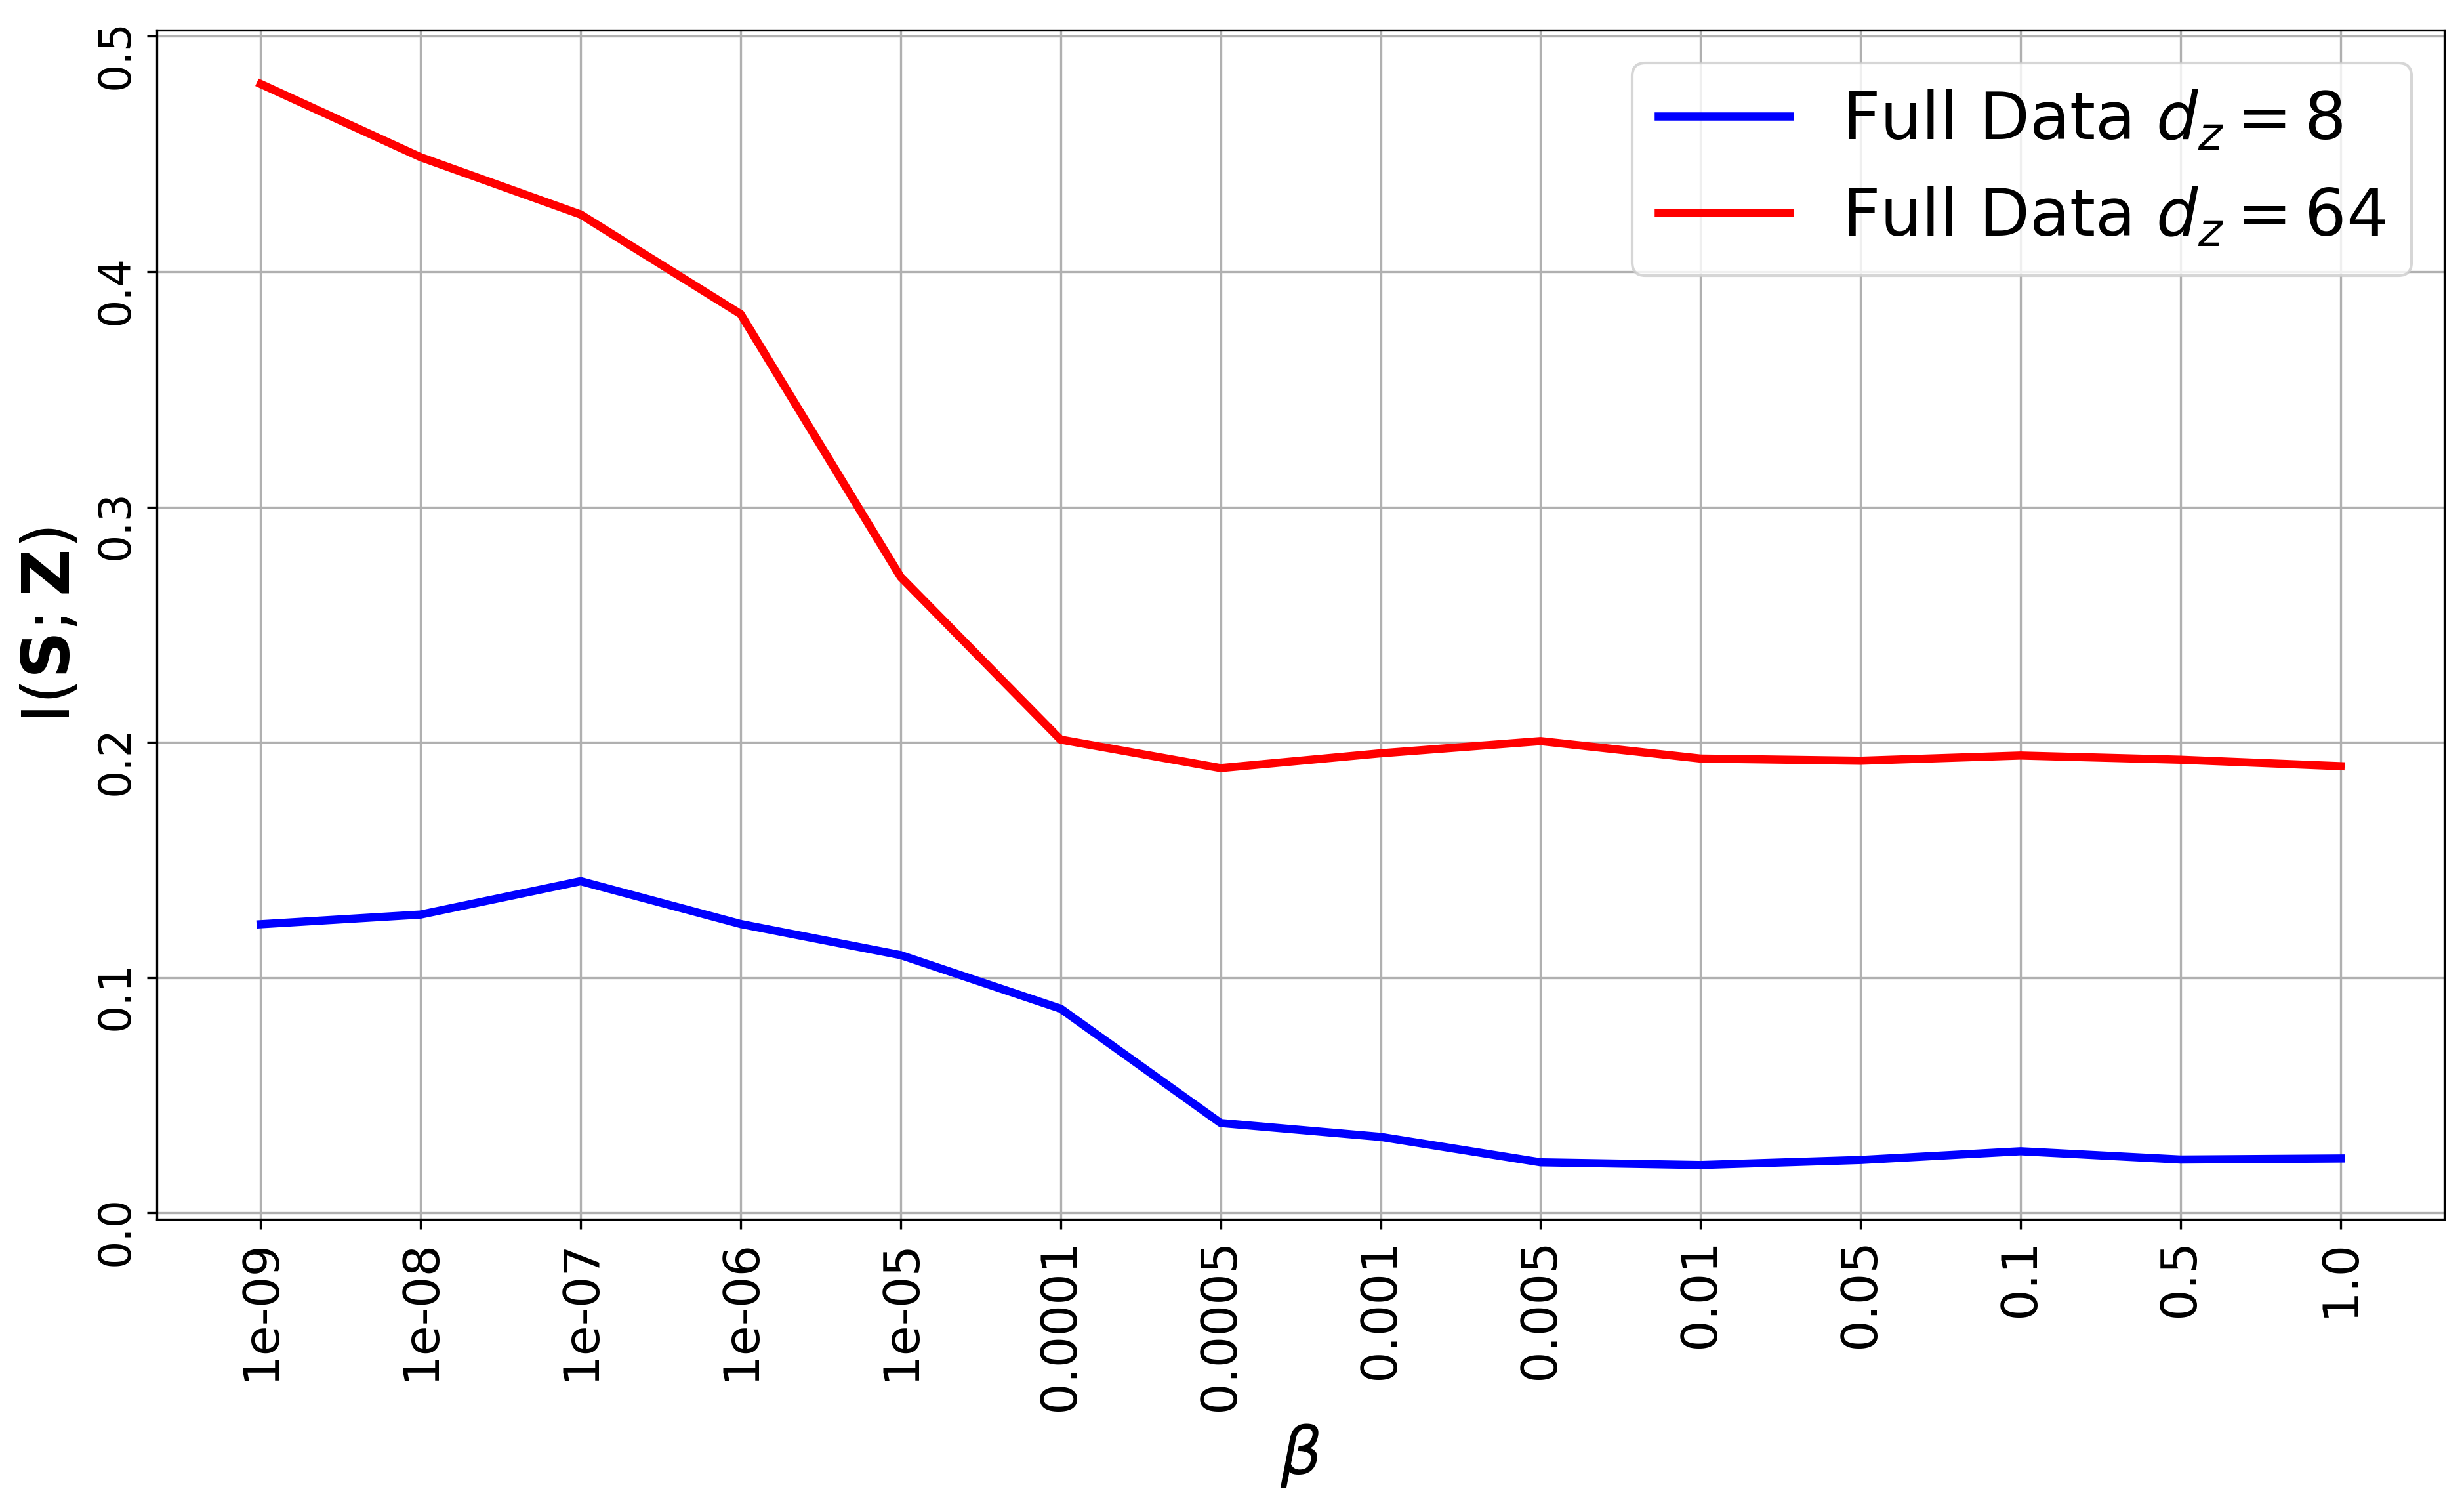

In [34]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(15,8))
# plt.title(r'Mutual Information with $\beta$ $\in$ [10e-9 1.0]' + f' - U is {utility} and S is {sensitive} - prior is {prior_type} - {data_type}', fontsize=20)
linestyles = ['-', '--', '-.', ':']
colors = ['b', 'r', 'g', 'c']
for i in range(mi_s.shape[0]):
    plt.plot(mi_s[i], label=f'Full Data ' + r'$d_z=$' + f'{DIM_Z[i]}', linestyle=linestyles[0], c=colors[i%len(colors)] ,linewidth=3)
        
# plt.xscale('linear')
plt.xlabel(r'$\beta$', fontsize=24)
plt.xticks(list(range(len(beta_list))), beta_list, fontsize=18)
plt.tick_params(labelrotation=90)

plt.ylabel(r'$\mathrm{I}(\mathbf{S};\mathbf{Z})$', fontsize=24)
plt.legend(prop={'size': 24})
plt.grid()
plt.savefig(f'./saved_figures/mi_zs_colored_mnist_s_{sensitive}_{prior_type}_{data_type}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./saved_figures/mi_zs_colored_mnist_s_{sensitive}_{prior_type}_{data_type}.png', format='png', bbox_inches='tight')
plt.show()

# Plot mutual information between Z and U

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


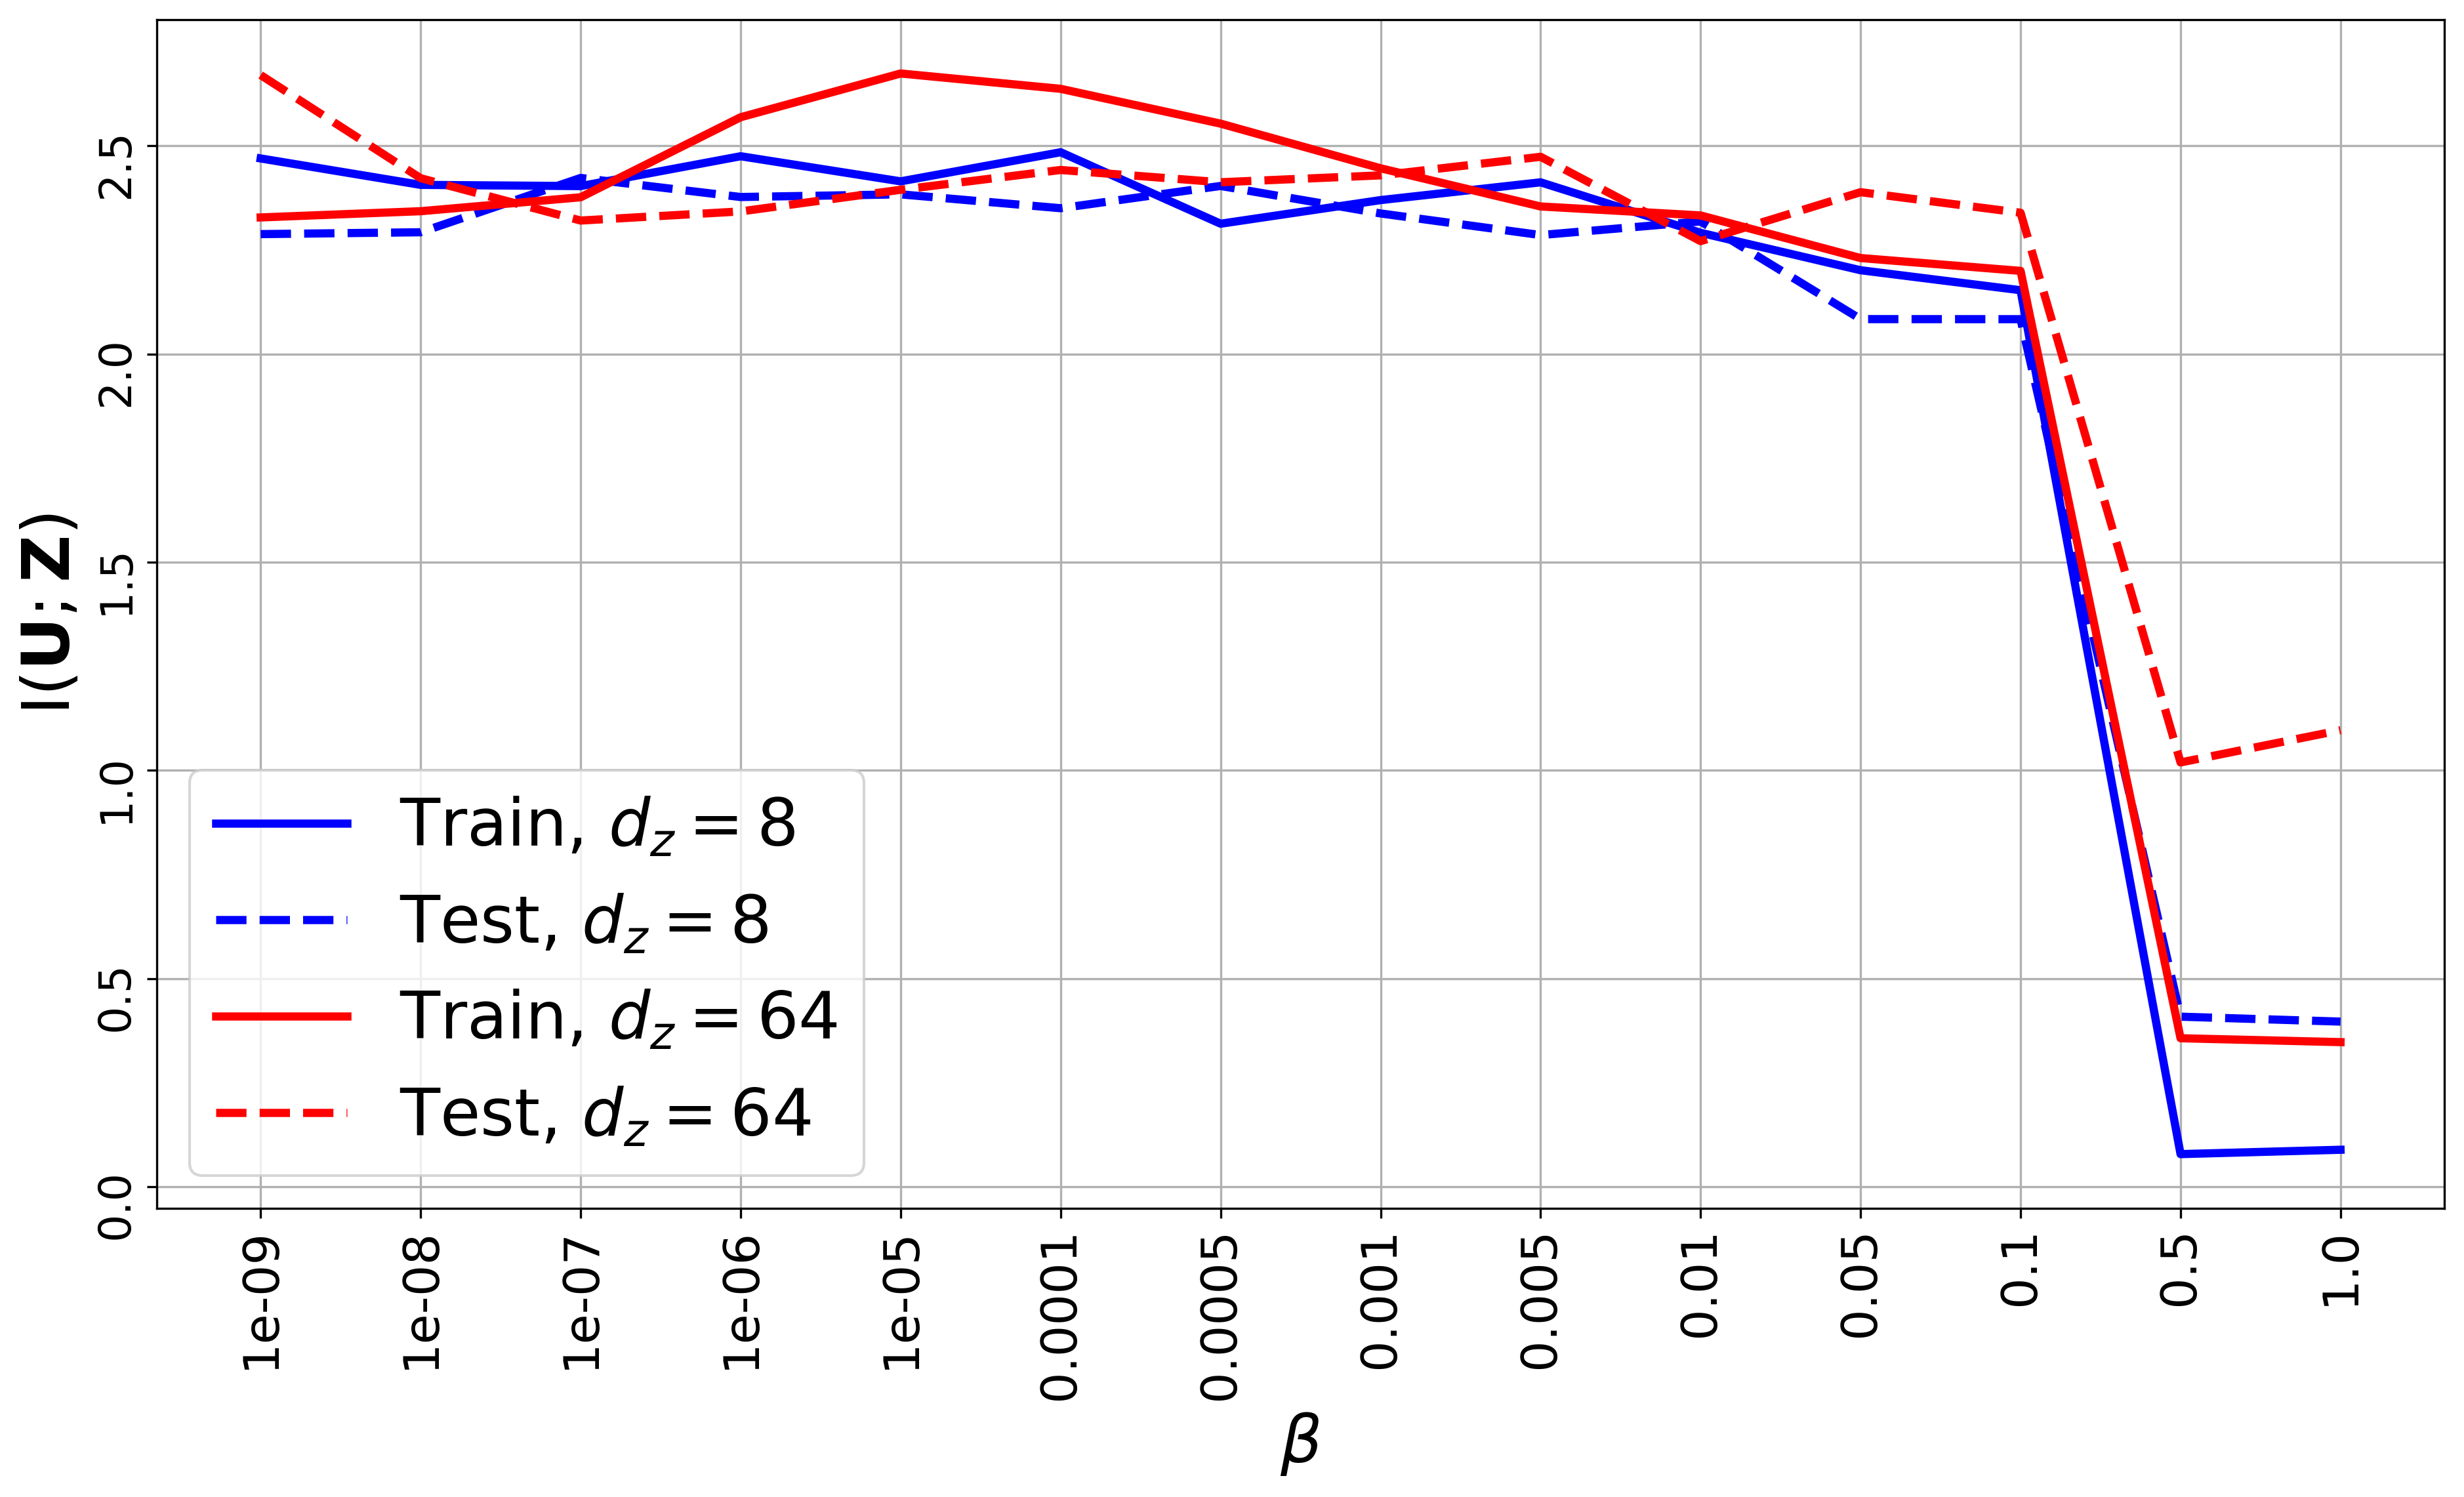

In [33]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(15,8))
linestyles = ['-', '--', '-.', ':']
colors = ['b', 'r', 'g', 'c']
# plt.title(r'Mutual Information with $\beta$ $\in$ [10e-9 1.0]' + f' - U is {utility} and S is {sensitive} - prior is {prior_type} - {data_type}', fontsize=20)
for i in range(mi_u_tr.shape[0]):
    plt.plot(mi_u_tr[i], label=f'Train, ' + r'$d_z=$' + f'{DIM_Z[i]}', linestyle=linestyles[0],c=colors[i%len(colors)], linewidth=3)
    plt.plot(mi_u_ts[i], label=f'Test, ' + r'$d_z=$' + f'{DIM_Z[i]}', linestyle=linestyles[1],c=colors[i%len(colors)], linewidth=3)
        
# plt.xscale('linear')
plt.xlabel(r'$\beta$', fontsize=24)
plt.xticks(list(range(len(beta_list))), beta_list, fontsize=18)
plt.tick_params(labelrotation=90)

plt.ylabel(r'$\mathrm{I}(\mathbf{U};\mathbf{Z})$', fontsize=24)
plt.legend(prop={'size': 24})
plt.grid()
plt.savefig(f'./saved_figures/mi_zu_colored_mnist_u_is_{utility}_{prior_type}_{data_type}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./saved_figures/mi_zu_colored_mnist_u_is_{utility}_{prior_type}_{data_type}.png', format='png', bbox_inches='tight')
plt.show()

# Save results to file

In [19]:
import scipy.io as sio
sio.savemat(f'./saved_data/acc_s_{sensitive}_u_{utility}_{prior_type}_{data_type}.mat', {'util_acc_ts':util_acc_tr, 'util_acc_tr':util_acc_tr, 'sens_acc_ts':sens_acc_ts})
sio.savemat(f'./saved_data/mi_s_{sensitive}_u_{utility}_{prior_type}_{data_type}.mat', {'mi_s':mi_s, 'mi_u_ts':mi_u_ts, 'mi_u_tr':mi_u_tr})

# Load results from file

In [31]:
beta_list = [10.0**i for i in range(-9,-3)]
beta_list.extend([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0])
DIM_Z = [8, 64]
s_data_ratio = [0.01, 1.0]


import scipy.io as sio
mat_contents  = sio.loadmat(f'./saved_data/acc_s_{sensitive}_u_{utility}_{prior_type}_{data_type}.mat')
util_acc_ts = mat_contents['util_acc_ts']
util_acc_tr = mat_contents['util_acc_tr']
sens_acc_ts = mat_contents['sens_acc_ts']


mat_contents  = sio.loadmat(f'./saved_data/mi_s_{sensitive}_u_{utility}_{prior_type}_{data_type}.mat')
mi_s = mat_contents['mi_s']
mi_u_ts = mat_contents['mi_u_ts']
mi_u_tr = mat_contents['mi_u_tr']